# Exercise 2 - Part 2
## Q2: Implementing a regression model ignoring heterozygous markers, creating a Manhatten plot, and comparing to the original phenotype publication.
### - Chosen phenotype: ```Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]```

####  Import libraries

In [44]:
import os
import pandas as pd
import numpy as np
from scipy.stats import f
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### Running the regression model

In [20]:
def calc_pvalues(genotype_filename, phenotype_filename, phenotype_index):
    """Calculate p-values for the given phenotype index using linear regression ignoring heterozygous markers"""
    
    # Validate inputs
    if not os.path.isfile(genotype_filename):
        raise FileNotFoundError('Genotype file not found')
    if not os.path.isfile(phenotype_filename):
        raise FileNotFoundError('Phenotype file not found')

    # Read genotypes table
    gens_tbl = pd.read_excel(genotype_filename, skiprows=1)
    genes = {'position': gens_tbl['Build37_position'].values,
             'chr': gens_tbl['Chr_Build37'].values,
             'locus': gens_tbl['Locus'].values,
             'data': gens_tbl.iloc[:, 4:]}

    # Read phenotypes
    phno_tbl = pd.read_excel(phenotype_filename)
    pheno = {'data': phno_tbl.iloc[:, 7:],  # zero-indexed so column 6 is index 5
             'index': phno_tbl.iloc[:, 0].values}

    # Filter relevant data
    cur_pheno = pheno['data'][pheno['index'] == phenotype_index]    # select relevant phenotype data
    cur_pheno_strains = cur_pheno.columns[~cur_pheno.isna().any()].tolist() # remove strains with missing data for the phenotype
    cur_genes = genes['data'][cur_pheno_strains].apply(lambda x: x.str.upper()) # filter genotypes for relevant strains
    cur_pheno = cur_pheno[cur_pheno_strains].values[0]  # convert phenotype data to numpy array
    
    # store the filtered date in the dictionaries
    genes['current'] = cur_genes
    pheno['current'] = cur_pheno

    # Linear regression
    k = 2
    Xtotal = cur_genes.map(lambda x: 1 if x == 'D' else (0 if x == 'B' else np.nan)).values

    p_values = np.zeros(Xtotal.shape[0])

    for i in range(Xtotal.shape[0]):
        X = Xtotal[i, :]
        Y = cur_pheno
        valid_inds = ~np.isnan(X)
        X = X[valid_inds]
        Y = Y[valid_inds]
        n = len(Y)

        if n < k:
            continue

        Xav = np.mean(X)
        Yav = np.mean(Y)

        Sxx = np.sum(X**2) - n * Xav**2
        Sxy = np.sum(X * Y) - n * Xav * Yav

        b1 = Sxy / Sxx
        b0 = Yav - b1 * Xav
        Yhat = X * b1 + b0

        SST = np.sum((Y - Yav)**2)
        SSE = np.sum((Y - Yhat)**2)
        SSR = np.sum((Yhat - Yav)**2)

        MSR = SSR / (k-1)
        MSE = SSE / (n-k)

        F = MSR / MSE
        p_values[i] = 1 - f.cdf(F, k-1, n-k)

    # Write to excel
    results = pd.DataFrame({'Locus': genes['locus'],
                            'Chromosome': genes['chr'],
                            'Position': genes['position'],
                            'pValue_Negative_Log10': -np.log10(p_values)})
    results.to_csv('output/pval_results.csv', index=False)
    
    return p_values, genes

##### Run the model

In [31]:
# define run params
phenotype_idx = 787
genotypes_filename = 'data/genotypes.xls'
phenotypes_filename = 'data/phenotypes.xls'

# run the model
p_values, genes = calc_pvalues(genotypes_filename, phenotypes_filename, phenotype_idx)

#### Create a Manhattan plot

There are a total of 3796 loci
There are at least 19 recombination events



/var/folders/6b/mjfxydrs1hb4_cf4_vhhd8lc0000gn/T/ipykernel_18433/1875376027.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_chromosomes))  # Use cm.get_cmap to get the colormap


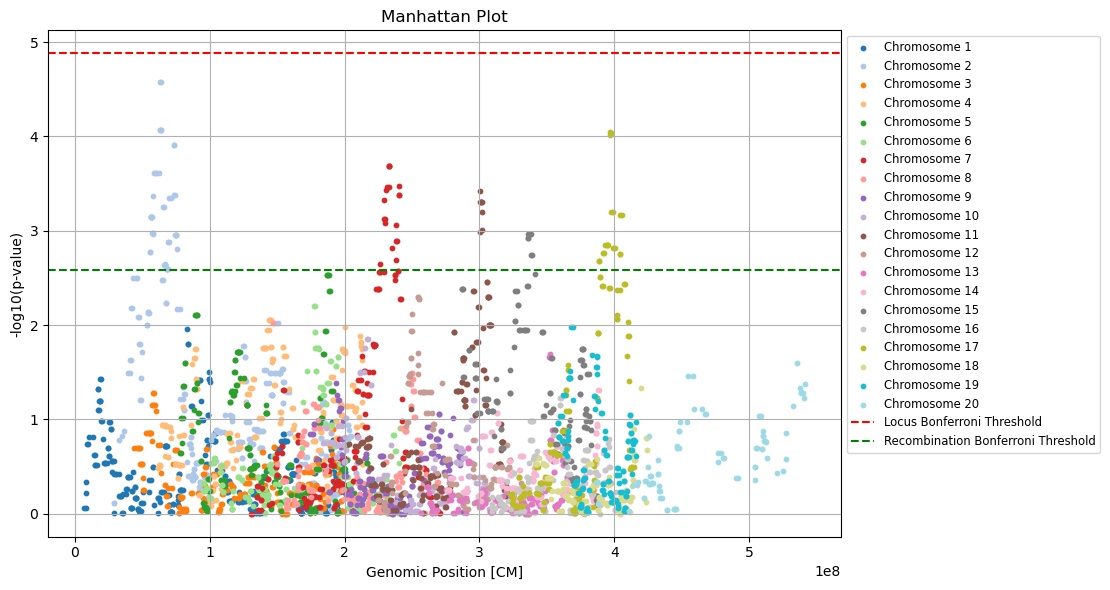

In [56]:
def prepare_genes_data(genes):
    """Add an 'abs_pos' column to the genes DataFrame."""
    pos = np.zeros(len(genes['position']))
    pos_diff = np.diff(genes['position'])
    pos[np.concatenate(([True], pos_diff < -1e6))] = genes['position'][np.concatenate(([True], pos_diff < -1e6))]
    abs_pos = np.cumsum(pos) + genes['position']
    genes['abs_pos'] = abs_pos

def plot_manhattan(genes, p_values, alpha=0.05):
    """Plot a Manhattan plot for the given genes and p-values, including Bonferroni correction."""
    
    # Number of loci
    num_loci = len(p_values)
    
    # Compute Bonferroni thresholds
    bonferroni_threshold_loci = alpha / num_loci
    bonferroni_threshold_recom = alpha / np.sum(np.diff(genes['chr']) != 0)
    print(f'There are a total of {num_loci} loci\n'
          f'There are at least {np.sum(np.diff(genes["chr"]) != 0)} recombination events\n')

    # Set up figure
    plt.figure(figsize=(14, 6))

    # Define offset and colors
    unique_chromosomes = np.unique(genes['chr'])
    colors = cm.get_cmap('tab20', len(unique_chromosomes))  # Use cm.get_cmap to get the colormap

    # Plot data points
    for idx, chr_num in enumerate(unique_chromosomes):
        # Calculate the offset for this chromosome
        chr_mask = genes['chr'] == chr_num
        offset = (chr_num - 1) * (genes['abs_pos'].max() - genes['abs_pos'].min()) / len(unique_chromosomes)
        # Plot the data
        plt.scatter(genes['abs_pos'][chr_mask] + offset, -np.log10(p_values[chr_mask]), 
                    label=f'Chromosome {chr_num}', color=colors(idx / len(unique_chromosomes)), s=10)

    # Plot significance thresholds
    plt.axhline(y=-np.log10(bonferroni_threshold_loci), color='r', linestyle='--', label='Locus Bonferroni Threshold')
    plt.axhline(y=-np.log10(bonferroni_threshold_recom), color='g', linestyle='--', label='Recombination Bonferroni Threshold')

    # Add labels and legend
    plt.xlabel('Genomic Position [CM]')
    plt.ylabel('-log10(p-value)')
    plt.title('Manhattan Plot')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout to fit the legend outside
    plt.savefig('output/manhattan_plot.png')
    plt.show()
    

# Plot Manhattan plot
prepare_genes_data(genes)
plot_manhattan(genes, p_values, alpha=0.05)
